# 小林由依さんの卒研：乳がんを細胞画像から判定
データセット：Breast Histopathology Images  
https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images


In [1]:
# 分類対象となる患者 ID を取得する
# (メモ) オリジナルデータのディレクトリが存在するため，これを除去するのが目的
# (ため息) ディスク上のデータを削除すれば早いだろうけど・・・
import glob
original_paths = glob.glob('BreastCancer/*')
target_paths = []
for path in original_paths:
    patient_id = path.split('/')[1]
    if patient_id.isnumeric():
        target_paths.append(path)
        
print(len(target_paths))

279


In [2]:
# (参考) 各患者について pos / neg の細胞画像数を数える
neg_total = 0
pos_total = 0
for path in target_paths:
    idc_negative = len(glob.glob(path + '/0/*'))
    idc_positive = len(glob.glob(path + '/1/*'))
    neg_total += idc_negative
    pos_total += idc_positive
    print("{}: neg:{}, pos:{}".format(path, idc_negative, idc_positive))
    
print("==================")
print("total: neg:{}, pos:{}".format(neg_total, pos_total))

BreastCancer/12878: neg:1289, pos:185
BreastCancer/14213: neg:169, pos:253
BreastCancer/10279: neg:1267, pos:427
BreastCancer/12951: neg:808, pos:330
BreastCancer/14079: neg:435, pos:455
BreastCancer/12931: neg:477, pos:130
BreastCancer/9324: neg:720, pos:322
BreastCancer/16896: neg:1017, pos:110
BreastCancer/13023: neg:112, pos:115
BreastCancer/13688: neg:215, pos:127
BreastCancer/9325: neg:1060, pos:68
BreastCancer/8959: neg:152, pos:204
BreastCancer/9225: neg:1454, pos:89
BreastCancer/12896: neg:424, pos:83
BreastCancer/14188: neg:586, pos:123
BreastCancer/10253: neg:479, pos:70
BreastCancer/9346: neg:634, pos:727
BreastCancer/9291: neg:733, pos:96
BreastCancer/9261: neg:521, pos:446
BreastCancer/14210: neg:469, pos:104
BreastCancer/12883: neg:276, pos:73
BreastCancer/12817: neg:362, pos:572
BreastCancer/10304: neg:779, pos:101
BreastCancer/16568: neg:545, pos:283
BreastCancer/9226: neg:817, pos:421
BreastCancer/15632: neg:373, pos:120
BreastCancer/12875: neg:331, pos:43
BreastCance

BreastCancer/13613: neg:827, pos:630
BreastCancer/8975: neg:1379, pos:833
BreastCancer/16551: neg:1899, pos:284
BreastCancer/12954: neg:1945, pos:64
BreastCancer/9035: neg:185, pos:51
BreastCancer/12898: neg:372, pos:208
BreastCancer/9382: neg:1306, pos:346
BreastCancer/14304: neg:410, pos:432
BreastCancer/10290: neg:1891, pos:140
BreastCancer/12890: neg:1313, pos:158
BreastCancer/14153: neg:579, pos:210
BreastCancer/16554: neg:269, pos:448
BreastCancer/9344: neg:225, pos:310
BreastCancer/14081: neg:117, pos:209
BreastCancer/12818: neg:666, pos:945
BreastCancer/12886: neg:240, pos:287
BreastCancer/15471: neg:448, pos:86
BreastCancer/8914: neg:978, pos:75
BreastCancer/13019: neg:1069, pos:441
BreastCancer/13020: neg:336, pos:50
BreastCancer/16533: neg:240, pos:127
BreastCancer/12911: neg:1041, pos:201
BreastCancer/9126: neg:1147, pos:447
BreastCancer/12626: neg:1088, pos:254
BreastCancer/14156: neg:1201, pos:197
BreastCancer/14078: neg:100, pos:121
BreastCancer/9255: neg:838, pos:388
Br

(メモ) negative / positive sample 数は，Kaggle のページにある説明と同じ数値となる。
```
total: neg:198738, pos:78786
```

In [2]:
# データセットを作る
X = []
y = []
for path in target_paths:
    neg_paths = glob.glob(path + '/0/*')
    pos_paths = glob.glob(path + '/1/*')
    
    X += neg_paths
    y += [0]*len(neg_paths)

    X += pos_paths
    y += [1]*len(pos_paths)

print(len(X))
print(len(y))

277524
277524


In [7]:
# 画像を１枚，表示してみる
from PIL import Image

#image_parent_dir = "Oxford/images/"
#path = image_parent_dir + df['Image'].iloc[0] + ".jpg"

im = Image.open(X[123])
print("Format:", im.format)
print("Mode:", im.mode)
print("Size:", im.size)

im.show()

Format: PNG
Mode: RGB
Size: (50, 50)


In [8]:
# 全画像サイズのチェック → 画像数が多すぎてチェックにかなりの時間を要するから動かさない方がよい
from PIL import Image

image_sizes = list()
for path in X:
    im = Image.open(path)
    image_sizes.append(im.size)
    im.close()
    
print(set(image_sizes))

KeyboardInterrupt: 

In [4]:
# 全画像のモードをチェック → 画像数が多すぎてチェックにかなりの時間を要するから動かさない方がよい
from PIL import Image

modes = list()
for path in X:
    im = Image.open(path)
    modes.append(im.mode)
    im.close()
    
import collections
collections.Counter(modes)

Counter({'RGB': 7346, 'RGBA': 3})

In [3]:
# 学習／テストへのデータセット分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
# Dataset クラスの定義

import numpy as np
from PIL import Image
from pathlib import Path
import torch
# import torch.utils.data as data
from torchvision import transforms

# Transformer の定義
transform = transforms.Compose([
    transforms.Resize((50,50)), #50),
    ### transforms.CenterCrop(224),
    # transforms.Grayscale(num_output_channels=3), # ResNet 等に喰わせるため，あえて３チャネル
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset : データソースから1個ずつデータを取り出すクラス
# 実装が必要なメソッドは__getitem__と__len__の2つ
# https://ohke.hateblo.jp/entry/2019/12/28/230000

# (メモ) このデータセットで transform=None はあり得ない！！
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None): #, input_size):
        super().__init__()
        
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels
        self.len = len(self.image_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        # 入力
        image = Image.open(image_path)
        
        # covert RGBA to RGB
        # Oxford-III Pet Dataset に少数ながら 'RGBA' が含まれるため，
        # これを RGB へ変換する
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        
        '''
        if self.transform:
            image = self.transform(image_array)
        else:
            image = torch.Tensor(np.transpose(image_array, (2, 0, 1)))/255  # for 0~1 scaling
        '''
        if self.transform:
            image = self.transform(image)
        else:
            image = np.asarray(image)
            image = torch.from_numpy(image)
                
        return image, label

train_dataset = MyDataset(X_train, y_train, transform=transform) #, (224, 224))
test_dataset = MyDataset(X_test, y_test, transform=transform) #, (224, 224))

# 動作チェック
image, label = train_dataset[0]
print(image.size(), label)  # torch.Size([3, 256, 256]) 1
print(type(image))
print(type(label))

torch.Size([3, 50, 50]) 1
<class 'torch.Tensor'>
<class 'int'>


In [5]:
# DataLoader の定義

BATCH_SIZE = 1024# 256 # 128 # 16

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, drop_last=True
)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, drop_last=True
)

# 動作チェック
images, labels = next(iter(trainloader))
print(images.size())  # torch.Size([16, 3, 224, 224])
print(labels.size())  # torch.Size([16])

torch.Size([1024, 3, 50, 50])
torch.Size([1024])


In [6]:
'''
とりあえず使わない
'''
# モデル / optimizer / criterion の定義

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

# GPUあれば使う
def check_cuda():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(check_cuda()) # "cuda"

import sys
print("device: {}".format(device), file=sys.stderr)

num_classes = 37 # クラス数

# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True) #ResNet
# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True) #ResNet

# ResNet18
net = models.resnet18(pretrained=True)
num_features = net.fc.in_features
net.fc = torch.nn.Linear(num_features, num_classes)

# ResNet50
'''
net = models.resnet50(pretrained=True)
num_features = net.fc.in_features
net.fc = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# VGG16
'''
net = models.vgg16(pretrained=True)
num_features = net.classifier[6].in_features # in_features = 4096
net.classifier[6] = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# VGG19
'''
net = models.vgg19(pretrained=True)
num_features = net.classifier[6].in_features # in_features = 4096
net.classifier[6] = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# Inception v3
# aux_logits の扱いについて：
# https://discuss.pytorch.org/t/error-in-training-inception-v3/23933/7
'''
num_classes = 3 # 3 : number of class (normal, pneumonia, COVID-19)
net = models.inception_v3(pretrained=True, aux_logits=False)
#num_ftrs = net.AuxLogits.fc.in_features
#net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
num_features = net.fc.in_features # in_features = 2048
net.fc = torch.nn.Linear(num_features, num_classes)
'''

# SqueezeNet 1.1
'''
num_classes = 3 # 3 : number of class
net = models.squeezenet1_1(pretrained=True)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
net.num_classes = num_classes
'''

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)

print(net)

device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# モデル / optimizer / criterion の定義

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# GPUあれば使う
def check_cuda():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(check_cuda()) # "cuda"

import sys
print("device: {}".format(device), file=sys.stderr)

num_classes = 37 # クラス数


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print("before avg:", x.shape)
        x = self.avg(x)
        # print("before:", x.shape)
        x = x.view(-1, 128)
        # print("after:", x.shape)
        x = self.fc(x)
        
        return x

net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

print(net)

device: cuda


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [7]:
from tqdm import tqdm

# 学習
# https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

EPOCH = 50 # 30

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #tes%MCEPASTEBIN%tのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力

    # 学習
    net.train() # 学習モード
    for (inputs, labels) in tqdm(trainloader):
        # print("inputs", inputs.shape)
        # print("labels", labels.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計

    net.eval() # 評価モード
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
    print("train mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)))  #lossとaccuracy出力
    train_loss_value.append(sum_loss*BATCH_SIZE/len(trainloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct/sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print('epoch{}'.format(epoch+1), file=fp)
        print("train  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''
        
    #test dataを使ってテストをする
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0

    cm_predicted_list = [] # confusion matrix で利用するため予測値を蓄える
    cm_true_list = [] # confusion matrix で利用するため真値を蓄える
    
    net.eval() # 評価モード
    for (inputs, labels) in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
        
        # confusion matrix のため予測値／真値を蓄える
        cm_predicted_list += predicted.tolist()
        cm_true_list += labels.tolist()
    print("test  mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(testloader.dataset))
    test_acc_value.append(float(sum_correct/sum_total))

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print("test  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''

epoch 1


  0%|          | 0/216 [00:00<?, ?it/s]/home/muto/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 216/216 [00:21<00:00, 10.09it/s]


train mean loss=0.3496402414384175, accuracy=0.8507080078125
test  mean loss=0.34811446122270095, accuracy=0.8525028935185185
epoch 2


100%|██████████| 216/216 [00:22<00:00,  9.75it/s]


train mean loss=0.33263839542919715, accuracy=0.8565221715856481
test  mean loss=0.33257716798898324, accuracy=0.85693359375
epoch 3


100%|██████████| 216/216 [00:22<00:00,  9.66it/s]


train mean loss=0.3334320932812637, accuracy=0.859375
test  mean loss=0.3328615628967478, accuracy=0.8598090277777778
epoch 4


100%|██████████| 216/216 [00:22<00:00,  9.67it/s]


train mean loss=0.33939624815397096, accuracy=0.8509837962962963
test  mean loss=0.33942356025428455, accuracy=0.8540219907407407
epoch 5


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.32618585401611006, accuracy=0.861328125
test  mean loss=0.3276805105536663, accuracy=0.8616898148148148
epoch 6


100%|██████████| 216/216 [00:22<00:00,  9.66it/s]


train mean loss=0.3080771406894476, accuracy=0.8685438368055556
test  mean loss=0.3108269626434274, accuracy=0.8685980902777778
epoch 7


100%|██████████| 216/216 [00:22<00:00,  9.50it/s]


train mean loss=0.30114217085191397, accuracy=0.8720477068865741
test  mean loss=0.30405113220902114, accuracy=0.8719075520833334
epoch 8


100%|██████████| 216/216 [00:23<00:00,  9.32it/s]


train mean loss=0.29678819412982566, accuracy=0.8737476490162037
test  mean loss=0.30018431726484385, accuracy=0.8734266493055556
epoch 9


100%|██████████| 216/216 [00:22<00:00,  9.54it/s]


train mean loss=0.29639175550638225, accuracy=0.8748734085648148
test  mean loss=0.29986980009719, accuracy=0.8738064236111112
epoch 10


100%|██████████| 216/216 [00:22<00:00,  9.64it/s]


train mean loss=0.2951571859407567, accuracy=0.8746021412037037
test  mean loss=0.29964959629376015, accuracy=0.8730287905092593
epoch 11


100%|██████████| 216/216 [00:22<00:00,  9.66it/s]


train mean loss=0.30474660694025973, accuracy=0.8702302155671297
test  mean loss=0.30920117268872876, accuracy=0.8680374710648148
epoch 12


100%|██████████| 216/216 [00:22<00:00,  9.69it/s]


train mean loss=0.2977573453417046, accuracy=0.8733904803240741
test  mean loss=0.30368171419047973, accuracy=0.8713650173611112
epoch 13


100%|██████████| 216/216 [00:22<00:00,  9.61it/s]


train mean loss=0.3043966445351383, accuracy=0.8701850043402778
test  mean loss=0.3098981770188215, accuracy=0.8686704282407407
epoch 14


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.2966673229730356, accuracy=0.8765100549768519
test  mean loss=0.3042235047051997, accuracy=0.8736074942129629
epoch 15


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.29208527553580804, accuracy=0.8772922092013888
test  mean loss=0.2986994409419408, accuracy=0.8739510995370371
epoch 16


100%|██████████| 216/216 [00:22<00:00,  9.60it/s]


train mean loss=0.2864399013772118, accuracy=0.8779296875
test  mean loss=0.2945364160780842, accuracy=0.8753436053240741
epoch 17


100%|██████████| 216/216 [00:22<00:00,  9.51it/s]


train mean loss=0.30242268619777296, accuracy=0.8721155237268519
test  mean loss=0.31112456140019057, accuracy=0.8678385416666666
epoch 18


100%|██████████| 216/216 [00:22<00:00,  9.61it/s]


train mean loss=0.2831520544923098, accuracy=0.8800320095486112
test  mean loss=0.2925266066216937, accuracy=0.8768446180555556
epoch 19


100%|██████████| 216/216 [00:22<00:00,  9.43it/s]


train mean loss=0.2811895920500206, accuracy=0.8800998263888888
test  mean loss=0.2906503361051721, accuracy=0.8762839988425926
epoch 20


100%|██████████| 216/216 [00:22<00:00,  9.55it/s]


train mean loss=0.29187141812849227, accuracy=0.8772967303240741
test  mean loss=0.30229420656342193, accuracy=0.8742947048611112
epoch 21


100%|██████████| 216/216 [00:22<00:00,  9.61it/s]


train mean loss=0.2815838876843425, accuracy=0.8814290364583334
test  mean loss=0.29104704702666145, accuracy=0.8766818576388888
epoch 22


100%|██████████| 216/216 [00:22<00:00,  9.63it/s]


train mean loss=0.28087537957759245, accuracy=0.8814606843171297
test  mean loss=0.2926250029250251, accuracy=0.8773690682870371
epoch 23


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.2811316091464204, accuracy=0.8818449797453703
test  mean loss=0.2934783443460893, accuracy=0.8771701388888888
epoch 24


100%|██████████| 216/216 [00:22<00:00,  9.67it/s]


train mean loss=0.3251104885906443, accuracy=0.86376953125
test  mean loss=0.335818658761211, accuracy=0.8586516203703703
epoch 25


100%|██████████| 216/216 [00:22<00:00,  9.63it/s]


train mean loss=0.27833017515709524, accuracy=0.8821524160879629
test  mean loss=0.2913971191934074, accuracy=0.8780924479166666
epoch 26


100%|██████████| 216/216 [00:22<00:00,  9.57it/s]


train mean loss=0.27866448056658705, accuracy=0.8825050636574074
test  mean loss=0.29142265488205593, accuracy=0.8766095196759259
epoch 27


100%|██████████| 216/216 [00:22<00:00,  9.66it/s]


train mean loss=0.2807289843007964, accuracy=0.8804615162037037
test  mean loss=0.293908404401912, accuracy=0.8759765625
epoch 28


100%|██████████| 216/216 [00:22<00:00,  9.66it/s]


train mean loss=0.2921859737568385, accuracy=0.8776403356481481
test  mean loss=0.3073166120354093, accuracy=0.8727575231481481
epoch 29


100%|██████████| 216/216 [00:22<00:00,  9.60it/s]


train mean loss=0.3455543259135919, accuracy=0.8520553023726852
test  mean loss=0.3574071465091827, accuracy=0.8470413773148148
epoch 30


100%|██████████| 216/216 [00:22<00:00,  9.62it/s]


train mean loss=0.27878397662551807, accuracy=0.8841145833333334
test  mean loss=0.29255137201709025, accuracy=0.8769712094907407
epoch 31


100%|██████████| 216/216 [00:22<00:00,  9.66it/s]


train mean loss=0.28248058028357703, accuracy=0.8824101200810185
test  mean loss=0.2968037464996467, accuracy=0.8758861400462963
epoch 32


100%|██████████| 216/216 [00:22<00:00,  9.64it/s]


train mean loss=0.2876732081455532, accuracy=0.8801721643518519
test  mean loss=0.30276408434751795, accuracy=0.8739149305555556
epoch 33


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.26832262839626847, accuracy=0.8876274956597222
test  mean loss=0.28442668387314485, accuracy=0.8795753761574074
epoch 34


100%|██████████| 216/216 [00:22<00:00,  9.60it/s]


train mean loss=0.281014479234485, accuracy=0.8839744285300926
test  mean loss=0.29934679242192425, accuracy=0.8779477719907407
epoch 35


100%|██████████| 216/216 [00:22<00:00,  9.60it/s]


train mean loss=0.26551353927400007, accuracy=0.8884865089699074
test  mean loss=0.28259615920898173, accuracy=0.8804976851851852
epoch 36


100%|██████████| 216/216 [00:22<00:00,  9.61it/s]


train mean loss=0.27042769731113686, accuracy=0.8863751446759259
test  mean loss=0.288991545599953, accuracy=0.8781286168981481
epoch 37


100%|██████████| 216/216 [00:22<00:00,  9.63it/s]


train mean loss=0.2663619448940524, accuracy=0.8886447482638888
test  mean loss=0.2854170151588434, accuracy=0.8804072627314815
epoch 38


100%|██████████| 216/216 [00:22<00:00,  9.64it/s]


train mean loss=0.2840737869582759, accuracy=0.8841145833333334
test  mean loss=0.30142767064024356, accuracy=0.8755244502314815
epoch 39


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.26508567848236664, accuracy=0.8875189887152778
test  mean loss=0.28410152500249836, accuracy=0.8796657986111112
epoch 40


100%|██████████| 216/216 [00:22<00:00,  9.51it/s]


train mean loss=0.2692013414260505, accuracy=0.8858913845486112
test  mean loss=0.28913899545314753, accuracy=0.8788158275462963
epoch 41


100%|██████████| 216/216 [00:22<00:00,  9.58it/s]


train mean loss=0.26891382212673626, accuracy=0.8890064380787037
test  mean loss=0.28768743967410737, accuracy=0.8807327835648148
epoch 42


100%|██████████| 216/216 [00:22<00:00,  9.51it/s]


train mean loss=0.26623916449003504, accuracy=0.8871934678819444
test  mean loss=0.2867893849565214, accuracy=0.8786530671296297
epoch 43


100%|██████████| 216/216 [00:22<00:00,  9.63it/s]


train mean loss=0.30127625581392037, accuracy=0.8705873842592593
test  mean loss=0.32058068356120084, accuracy=0.8640950520833334
epoch 44


100%|██████████| 216/216 [00:22<00:00,  9.57it/s]


train mean loss=0.2710299425452995, accuracy=0.8850188078703703
test  mean loss=0.29342954206247607, accuracy=0.8759765625
epoch 45


100%|██████████| 216/216 [00:22<00:00,  9.60it/s]


train mean loss=0.2632133276295601, accuracy=0.8891013816550926
test  mean loss=0.2853698933900944, accuracy=0.8795572916666666
epoch 46


100%|██████████| 216/216 [00:22<00:00,  9.61it/s]


train mean loss=0.25846203800274764, accuracy=0.8918728298611112
test  mean loss=0.2812952394711414, accuracy=0.8811125578703703
epoch 47


100%|██████████| 216/216 [00:22<00:00,  9.57it/s]


train mean loss=0.28056475096426853, accuracy=0.8800817418981481
test  mean loss=0.3035661157708202, accuracy=0.8729564525462963
epoch 48


100%|██████████| 216/216 [00:22<00:00,  9.59it/s]


train mean loss=0.2895750996164655, accuracy=0.8810989945023148
test  mean loss=0.3111024021361392, accuracy=0.8702256944444444
epoch 49


100%|██████████| 216/216 [00:22<00:00,  9.54it/s]


train mean loss=0.2600447658791924, accuracy=0.8912896050347222
test  mean loss=0.28376936201640757, accuracy=0.87939453125
epoch 50


100%|██████████| 216/216 [00:22<00:00,  9.53it/s]


train mean loss=0.2545465983931001, accuracy=0.8930980541087963
test  mean loss=0.2796995115713991, accuracy=0.8820710358796297


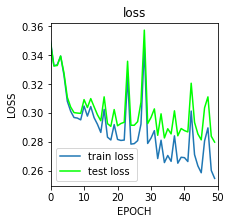

In [8]:
# 損失の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss_image.png")

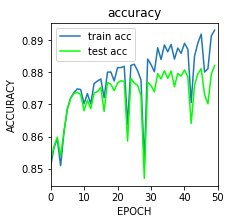

In [9]:
# 正解率の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_acc_value)
plt.plot(range(EPOCH), test_acc_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 1)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")

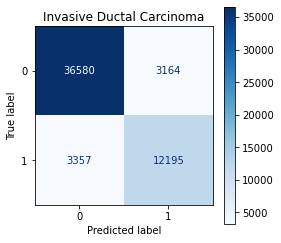

In [10]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(cm_true_list, cm_predicted_list)
cmp = ConfusionMatrixDisplay(cm) #, display_labels=class_names)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('Invasive Ductal Carcinoma')
cmp.plot(cmap=plt.cm.Blues, xticks_rotation='horizontal', ax=ax)